In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 16 11:57:09 2019

@author: smrak
"""
from pyGnss import pyGnss
import multiprocessing as mp
from pyGnss import gnssUtils as gu
from datetime import datetime, timedelta
import georinex as gr
import numpy as np
import subprocess
from glob import glob
from dateutil import parser
import os
import xarray as xr
import astropy.time as at
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def get_sat_bias(ionexfolder, date):
    year = date.year
    doy = date.strftime("%j")
    yy = date.strftime("%y")
        # ionex = get_ioniex_files(date)
    ionex_files = sorted(glob(ionexfolder+ f"*{year}{doy}*.INX") + glob(ionexfolder+ f"*{doy}0.{yy}i"))
    if len(ionex_files) > 0:
        sat_bias = pyGnss.getSatBias(ionex_files[0])
    else:
        sat_bias=None
    return sat_bias

def get_nav_files(navfolder, times):
    if not isinstance(times.dtype, datetime):
        times = times.astype('datetime64[s]').astype(datetime)
    days = np.unique([date.date() for date in times]).astype('datetime64[s]').astype(datetime)
    for i, day in enumerate(days):
        # d = day.day
        year = day.year
        doy = day.strftime('%j')
        yy = day.strftime('%y')
     
        gps_ts = (day - datetime(1980, 1, 6)).total_seconds()
        wwww = int(gps_ts / 60 /60 / 24 / 7)
        weekday = (day.weekday() + 1 ) % 7
        wwwwd = str(wwww) + str(weekday)
        tmp = glob(navfolder + os.sep + f"GFZ*{year}{doy}*SP3")[0] if len(glob(navfolder + f"GFZ*{year}{doy}*SP3")) > 0 else None
        if tmp is None:
            tmp = glob(navfolder + os.sep + f"IGS*{year}{doy}*SP3")[0] if len(glob(navfolder + f"IGS*{year}{doy}*SP3")) > 0 else None
        if tmp is None:
            tmp = glob(navfolder + os.sep + f"igs*{doy}*.{yy}sp3")[0] if len(glob(navfolder + f"igs*{doy}*.{yy}sp3")) > 0 else None
        if tmp is None:
            tmp = glob(navfolder + os.sep + f"gfz*{wwwwd}.sp3")[0] if len(glob(navfolder + f"gfz*{wwwwd}.sp3")) > 0 else None
        if tmp is None:
            tmp = glob(navfolder + os.sep + f"brdc*{doy}*{yy}n")[0] if len(glob(navfolder + f"brdc*{doy}*{yy}n")) > 0 else None    
        if tmp is None:
            print (f"Navigation file wasn't found. Sepcified nav_file {navfolder}")
        if i == 0:
            fsp3 = tmp
        else:
            fsp3 = np.hstack((fsp3, tmp))
            
    return fsp3


In [13]:

def do_one(fnc, fsp3, sat_bias, t, ts, odir, use, roti_cutoff=0.5, snr_cutoff=30, Hipp=450, el_mask=30,
           window_size0=5, window_size1=30, window_size2=60, window_size3=90):
    sfn = odir+os.sep+os.path.split(fnc[0])[1][:4].lower()+".nc"
    # if os.path.exists(sfn):
    #      return
    # try:
    t0 = datetime.now()
    for ifn, fn in enumerate(fnc):
        if ifn == 0:
            tmp = gr.load(fn, use = use, fast=1, interval=ts, tlim=(t[0].astype(datetime), t[-1].astype(datetime)))
            if tmp.sizes["time"] > 0:
                D = tmp
        else:
            tmp = gr.load(fn, use = use, fast=1, interval=ts, tlim=(t[0].astype(datetime), t[-1].astype(datetime)))
            if tmp.sv.size != np.unique(tmp.sv).size:
                tmp = tmp.groupby('sv').sum()
            if tmp.sizes["time"] == 0:
                continue
            if 'D' not in locals():
                D = tmp
            else:
                if D.sv.size != tmp.sv.size:
                    D = D.reindex(sv = np.union1d(D.sv.values, tmp.sv.values))
                D = xr.concat((D, tmp), dim='time')
    if 'D' not in locals():
        return
    print (f"It took {datetime.now()-t0} to load RINEX")
    tsps = D.interval
    svlist = D.sv.values
    dcb0 = np.zeros(svlist.size)
    sat_bias_keys = sat_bias.keys()
    print (sat_bias_keys)
    print (svlist)
    for isv, sv in enumerate(svlist):
        if sv in sat_bias_keys:
            dcb0[isv] = sat_bias[sv]
    print (dcb0)
    if np.isnan(tsps):
        tsps = int(np.nanmedian(np.diff(D.time)) / np.timedelta64(1, 's'))
    maxjump = 1.6 + (np.sqrt(tsps) - 1)
    N0 = int((60/tsps)*window_size0)
    N1 = int((60/tsps)*window_size1)
    N2 = int((60/tsps)*window_size2)
    N3 = int((60/tsps)*window_size3)
    NROTI = int((60/tsps) * 5) # ROTI over 5 min
    # eps = E0 * np.sqrt(30/tsps)
    # TODO Correct GPST too UTC time when calling AER in pyGnss
    STEC, TEC_sigma, AER = pyGnss.getSTEC(fnc=D, fsp3=fsp3, el_mask=el_mask,
                                maxgap=1, maxjump=maxjump, return_aer=1,
                                return_tec_error=1,
                                )
    ROTI = pyGnss.getROTI(STEC, ts=tsps, N = NROTI)
    SNR = pyGnss.getCNR(D, fsp3=fsp3, el_mask=el_mask, H=Hipp)
    DCB = pyGnss.getDCBfromSTEC(STEC, AER, sb=-dcb0, el_mask=5, ROTI=ROTI, roti_cutoff=roti_cutoff, SNR=SNR, snr_cutoff=roti_cutoff)
    print (DCB)
    F = pyGnss.getMappingFunction(AER[:,:,1], Hipp)
    STECcorr = STEC - DCB
    VTEC = STECcorr * F
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.plot(D.time, STEC+dcb0)
    ax2.plot(D.time, STEC-DCB)
    plt.show()


    # 
    #     VTEC[TEC_sigma > 8] = np.nan
    #     D['stec'] = (("time", "sv"), STECcorr)
    #     O = D['stec'].to_dataset()
    #     O['tec_sigma'] = (("time", "sv"), TEC_sigma)
    #     O['snr'] = (("time", "sv"), SNR)
    #     O['roti'] = (("time", "sv"), ROTI)
    #     O['el'] = (("time", "sv"), AER[:,:,1])
    #     O['az'] = (("time", "sv"), AER[:,:,0])
    #     O['dtec0'] = (("time", "sv"), pyGnss.getDTECsg_from_VTEC(VTEC, N=N0, order=1))
    #     O['dtec1'] = (("time", "sv"), pyGnss.getDTECsg_from_VTEC(VTEC, N=N1, order=1))
    #     O['dtec2'] = (("time", "sv"), pyGnss.getDTECsg_from_VTEC(VTEC, N=N2, order=1))
    #     O['dtec3'] = (("time", "sv"), pyGnss.getDTECsg_from_VTEC(VTEC, N=N3, order=1))
    #     O = O.stack(flat=["time", "sv"]).reset_index("flat").dropna(dim="flat", subset=["stec"]).unstack()
    #     O['time'] = ("flat", O.time.values)
    #     O['sv'] = ("flat", O.sv.values)
        
    #     attrs={"title": "TEC Data",
    #         "position_geodetic": D.position_geodetic,
    #         "filename": D.filename,
    #         "ReferenceFrame": "WGS84",
    #         "svall": D.sv.values,
    #         "obstimes": gu.datetime2posix(D.time.values.astype('datetime64[s]').astype(datetime)),
    #         "satellite_type": use,
    #         "DataType": use,
    #         "DateSubmitted": datetime.now().strftime("%m/%d/%Y %H:%M:%S"),
    #         "DataInterval": ts,
    #         "Elevation mask": el_mask,
    #         "ROTI Cutoff": roti_cutoff,
    #         "Signal Strength Cutoff": snr_cutoff,
    #         "hipp": Hipp,
    #         "software": "nc2rnx",
    #         "author": "sm",
    #         "georinex": gr.__version__
    #         }
        
    #     if 'rxmodel' in D.attrs:
    #         attrs['rxmodel'] = D.attrs['rxmodel']
    #     if 'leap_seconds' in D.attrs:
    #         attrs["GPS_Leap_Seconds"] = D.leap_seconds,
    #     O.attrs = attrs
    #     comp = dict(zlib=True, complevel=9)
    #     encoding = {var: comp for var in O.data_vars}
    #     O.to_netcdf(sfn, mode='w', encoding=encoding)
    #     del D, O
    # except Exception as e:
    #     with open(sfn+'.txt', 'w') as f:
    #         f.write(str(e))
    
    return
    


In [ ]:

date = parser.parse('2015-3-25')
year = date.year
# yy = date.strftime("%y")
yeara = (date - timedelta(days=1)).year
yearz = (date + timedelta(days=1)).year
doy = date.strftime('%j')
mmdd = date.strftime('%m%d')
mmdda = (date - timedelta(days=1)).strftime('%m%d')
mmddz = (date + timedelta(days=1)).strftime('%m%d')

root = '/disks/d0395/mraks1/rinex/'
obsfolder = root
navfolder = root + 'nav/' 
ionexfolder = root + 'ionex/'
odir = '/disk1/tid/tests/'
# rxlist = obsfolder + f'{os.sep}{year}{os.sep}{mmdd}{os.sep}rxlist1227.2020.h5.yaml'
tlim = None
ts = 30
roti_cutoff = 0.5
snr_cutoff = 30
Hipp = 450
window_size0 = 5
window_size1 = 30
window_size2 = 60
window_size3 = 90
el_mask = 10
# E0 = 0.1
# polynom_list = np.arange(20)
# log = 0
year = date.year
doy = date.strftime('%j')
use = ('G', 'E', 'C')
# use = 'E'
rx0 = 'ab15'


    



In [16]:
# Filter input files
# stream = yaml.safe_load(open(rxlist, 'r'))
# rxn = np.array(stream.get('rx'))
# Obs files => Path to
assert os.path.exists(obsfolder), "Folder with observation files does not exists."
nc_list = np.array(sorted(glob(obsfolder + f'{year}{os.sep}{mmdd}{os.sep}' +  '*crx') + glob(obsfolder + f'{year}{os.sep}{mmdd}{os.sep}' + '*rnx') + glob(obsfolder + f'{year}{os.sep}{mmdd}{os.sep}' + '*.*d') + glob(obsfolder + f'{year}{os.sep}{mmdd}{os.sep}' + '*.*o')))
nc_lista = np.array(sorted(glob(obsfolder + f'{yeara}{os.sep}{mmdda}{os.sep}' +  '*crx') + glob(obsfolder + f'{yeara}{os.sep}{mmdda}{os.sep}' + '*rnx') + glob(obsfolder + f'{yeara}{os.sep}{mmdda}{os.sep}' + '*.*d') + glob(obsfolder + f'{yeara}{os.sep}{mmdda}{os.sep}' + '*.*o')))
nc_listz = np.array(sorted(glob(obsfolder + f'{yearz}{os.sep}{mmddz}{os.sep}' +  '*crx') + glob(obsfolder + f'{yearz}{os.sep}{mmddz}{os.sep}' + '*rnx') + glob(obsfolder + f'{yearz}{os.sep}{mmddz}{os.sep}' + '*.*d') + glob(obsfolder + f'{yearz}{os.sep}{mmddz}{os.sep}' + '*.*o')))
nc_rx_name, iux = np.unique([os.path.split(r)[1][:4] for r in nc_list], return_index=1)
nc_rx_namea, iua = np.unique([os.path.split(r)[1][:4] for r in nc_lista], return_index=1)
nc_rx_namez, iuz = np.unique([os.path.split(r)[1][:4] for r in nc_listz], return_index=1)

# idn = np.isin([n.lower() for n in nc_rx_name], rx0)
fn_list = nc_list[iux]
nc_list_all = np.empty(fn_list.size, dtype=object)
for i, nc_rx in enumerate(nc_rx_name):
    tmp = [nc_list[np.isin(nc_rx_name, nc_rx)].item()]
    ida = np.isin(nc_rx_namea, nc_rx)
    if np.sum(ida) > 0:
        tmp = list(nc_lista[iua][ida]) + tmp
    idz = np.isin(nc_rx_namez, nc_rx)
    if np.sum(idz) > 0:
        tmp = tmp + list(nc_listz[iuz][idz])
    nc_list_all[i] = tmp

if 'rx0' in locals():
    for i in range(nc_list_all.size):
        if rx0 in os.path.split(nc_list_all[i][0])[1].lower():
            idx = i

if 'idx' in locals():
    nc_list_all = [nc_list_all[idx]]
#Common time array
if tlim is None:
    delta_t = timedelta(hours=3)
    t0 = date 
    t1 = date + timedelta(days=1)
else:
    assert len(tlim) == 2
    t0 = datetime.strptime('{} {}-{}'.format(year,int(doy),tlim[0]),'%Y %j-%H:%M')
    t1 = datetime.strptime('{} {}-{}'.format(year,int(doy),tlim[1]),'%Y %j-%H:%M')
    delta_t = timedelta(seconds=0)
t = np.arange(t0-delta_t, t1+delta_t, ts, dtype='datetime64[s]') #datetime64[s]
tl = t.size

# Nav file
fsp3 = get_nav_files(navfolder, t)
# Break at the beginning 
assert not (fsp3==None).all(), "Cant find the sp3 file"
assert (np.array([os.path.exists(f) for f in fsp3])==1).all(), "Cant find the sp3 file in the directory"

sat_bias = get_sat_bias(ionexfolder, date)
print (sat_bias)
if not os.path.exists(odir):
    subprocess.call(f"mkdir -p {odir}", shell=True)




{'G32': -7.184, 'G04': -2.239, 'G08': -4.144, 'G10': -7.817, 'G14': 3.802, 'G13': 7.204, 'G28': 6.651, 'G21': 7.467, 'G11': 7.911, 'G22': 19.123, 'G20': 2.008, 'G18': 7.084, 'G16': 5.664, 'G19': 14.035, 'G23': 23.774, 'G02': 24.236, 'G31': 11.163, 'G17': 5.787, 'G12': 9.163, 'G15': 5.556, 'G29': 4.332, 'G07': 7.002, 'G05': 5.946, 'G25': -23.335, 'G01': -24.228, 'G30': -19.847, 'G24': -18.467, 'G27': -17.041, 'G06': -21.707, 'G09': -14.867, 'G03': -16.975, 'R01': -16.473, 'R02': 0.605, 'R03': 14.052, 'R04': 16.604, 'R05': -3.012, 'R06': 3.428, 'R07': 10.227, 'R08': 15.438, 'R09': 14.577, 'R10': -22.385, 'R11': -4.7, 'R12': -11.437, 'R13': -2.658, 'R14': -24.168, 'R15': -10.843, 'R16': -1.032, 'R17': 10.795, 'R18': -2.478, 'R19': 16.967, 'R20': -7.797, 'R21': 8.356, 'R22': 0.873, 'R23': -19.739, 'R24': 14.702}


In [9]:
print (nc_list_all)
print (t)

[['/disks/d0395/mraks1/rinex/2015/0324/ab150830.15d', '/disks/d0395/mraks1/rinex/2015/0325/ab150840.15d', '/disks/d0395/mraks1/rinex/2015/0326/ab150850.15d']]
['2015-03-24T21:00:00' '2015-03-24T21:00:30' '2015-03-24T21:01:00' ...
 '2015-03-26T02:58:30' '2015-03-26T02:59:00' '2015-03-26T02:59:30']


['/disks/d0395/mraks1/rinex/2015/0324/ab150830.15d', '/disks/d0395/mraks1/rinex/2015/0325/ab150840.15d', '/disks/d0395/mraks1/rinex/2015/0326/ab150850.15d']
It took 0:00:09.912803 to load RINEX
dict_keys(['G32', 'G04', 'G08', 'G10', 'G14', 'G13', 'G28', 'G21', 'G11', 'G22', 'G20', 'G18', 'G16', 'G19', 'G23', 'G02', 'G31', 'G17', 'G12', 'G15', 'G29', 'G07', 'G05', 'G25', 'G01', 'G30', 'G24', 'G27', 'G06', 'G09', 'G03', 'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20', 'R21', 'R22', 'R23', 'R24'])
['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G09' 'G10' 'G11' 'G12' 'G13'
 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24' 'G25'
 'G27' 'G28' 'G29' 'G30' 'G31' 'G32']
[-24.228  24.236 -16.975  -2.239   5.946 -21.707   7.002 -14.867  -7.817
   7.911   9.163   7.204   3.802   5.556   5.664   5.787   7.084  14.035
   2.008   7.467  19.123  23.774 -18.467 -23.335 -17.041   6.651   4.332
 -19.8

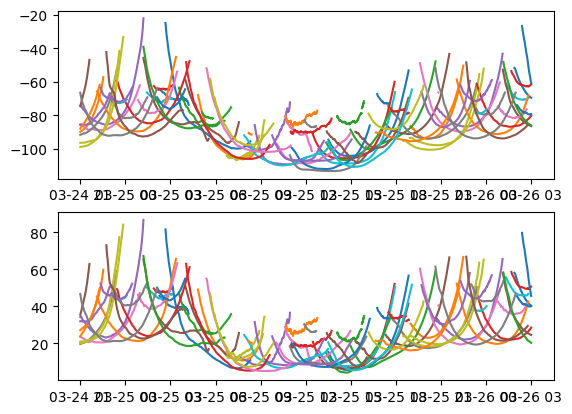

It took 0:00:14.628115 to complete 1/3923


In [14]:
for irx, fnc in enumerate(nc_list_all):
    print (fnc)
    # fnc=nc_list_all[2]
    # fnc = nc_list_all[::-1][32]
    # fnc = [fnc[1]]
    ts0 = datetime.now()
    do_one(fnc, fsp3, sat_bias, t, ts, odir, use, roti_cutoff, snr_cutoff, Hipp, el_mask, window_size0, window_size1, window_size2, window_size3)
    print (f"It took {datetime.now()-ts0} to complete {irx+1}/{fn_list.size}")
    # break
    # if irx > 20:
    break


In [7]:
R = gr.load(fnc[0])
R1 = gr.load(fnc[0], interval=30)
R2 = gr.load(fnc[0], interval=30, tlim=(t[0].astype(datetime), t[-1].astype(datetime)))
# R1 = R.resample(time='30S').median()
print (R.time)
print (R1.time)
print (R2.time)


<xarray.DataArray 'time' (time: 5760)>
array(['2015-03-25T00:00:00.000000000', '2015-03-25T00:00:15.000000000',
       '2015-03-25T00:00:30.000000000', ..., '2015-03-25T23:59:15.000000000',
       '2015-03-25T23:59:30.000000000', '2015-03-25T23:59:45.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-03-25 ... 2015-03-25T23:59:45
<xarray.DataArray 'time' (time: 2880)>
array(['2015-03-25T00:00:00.000000000', '2015-03-25T00:00:30.000000000',
       '2015-03-25T00:01:00.000000000', ..., '2015-03-25T23:58:30.000000000',
       '2015-03-25T23:59:00.000000000', '2015-03-25T23:59:30.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-03-25 ... 2015-03-25T23:59:30
<xarray.DataArray 'time' (time: 2880)>
array(['2015-03-25T00:00:00.000000000', '2015-03-25T00:00:30.000000000',
       '2015-03-25T00:01:00.000000000', ..., '2015-03-25T23:58:30.000000000',
       '2015-03-25T23:59:00.000000000', '2015-03-25T23:5